In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary
#vital params

 
model_name="DenseNet121_stn1"

dataset_name="cifar10"

#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


Model: DenseNet121_stn1 with 10 classes running on: cifar10


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Files already downloaded and verified
Files already downloaded and verified
Dataset size: Train: 40000, Valid: 10000, Test: 10000
torch.Size([3, 224, 224])
Datasets loaded and prepared


In [3]:
#model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
#from .utils import load_state_dict_from_url


__all__ = ['DenseNet', 'densenet121', 'densenet169', 'densenet201', 'densenet161']



class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),

        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function



class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)  

    def forward(self, init_features):
        features = [init_features] 
        for name, layer in self.named_children():   
            new_features = layer(*features) 
            features.append(new_features)  
        return torch.cat(features, 1)   


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=num_classes, memory_efficient=False):

        super(DenseNet, self).__init__()


        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,  
                num_input_features=num_features,    
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,    
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)  
            num_features = num_features + num_layers * growth_rate 
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)  
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2   

        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

        self.localization = nn.Sequential(
            #nn.Conv2d(3, 8, kernel_size=7),
            nn.Conv2d(3,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            nn.Conv2d(8,8,kernel_size=3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            
            
            #nn.Conv2d(8, 10, kernel_size=5),
            nn.Conv2d(8,10, kernel_size = 3),
            nn.Conv2d(10,10,kernel_size = 3),
            
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

        
    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        xs = xs.view(-1, 10 * 52 * 52)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        x=self.stn(x)
        features = self.features(x) 
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))   
        out = torch.flatten(out, 1)
        out = self.classifier(out) 
        return out

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet121(pretrained=False, progress=True, **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)


def densenet161(pretrained=False, progress=True, **kwargs):
    r"""Densenet-161 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet161', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)


def densenet169(pretrained=False, progress=True, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet169', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)


def densenet201(pretrained=False, progress=True, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet201', 32, (6, 12, 64, 48), 64, pretrained, progress,
                     **kwargs)


In [4]:
model = densenet121().to(device)
model = model.to(device)


#pretesting model for shape
x=torch.randn(64,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, 224, 224)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

torch.Size([64, 3, 224, 224])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


torch.Size([64, 10])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
            Conv2d-2          [-1, 8, 220, 220]             584
            Conv2d-3          [-1, 8, 218, 218]             584
         MaxPool2d-4          [-1, 8, 109, 109]               0
              ReLU-5          [-1, 8, 109, 109]               0
            Conv2d-6         [-1, 10, 107, 107]             730
            Conv2d-7         [-1, 10, 105, 105]             910
         MaxPool2d-8           [-1, 10, 52, 52]               0
              ReLU-9           [-1, 10, 52, 52]               0
           Linear-10                   [-1, 32]         865,312
             ReLU-11                   [-1, 32]               0
           Linear-12                    [-1, 6]             198
           Conv2d-13         [-1, 64, 112, 112]           9,408


In [5]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [6]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//DenseNet121_stn120211114014405
grandstore_string
grandstore/cifar10_DenseNet121_stn120211114014405.pkl


In [7]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [8]:
TOP_ACCURACY_TRACK = 15
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=300,
                    minepoch=150,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 54.650
Training Loss: 67572550.3218 	Validation Loss: 12515.8714

Running epoch: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 68.290
Training Loss: 46074414.9853 	Validation Loss: 8929.0692

Running epoch: 3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 71.800
Training Loss: 35472808.0571 	Validation Loss: 8076.1841

Running epoch: 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 78.790
Training Loss: 28348010.3490 	Validation Loss: 6182.1597

Running epoch: 5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 80.480
Training Loss: 22974671.0000 	Validation Loss: 5734.9886

Running epoch: 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 82.390
Training Loss: 19019160.3170 	Validation Loss: 5191.7531

Running epoch: 7


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 83.480
Training Loss: 15929288.5250 	Validation Loss: 4887.6410

Running epoch: 8


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.630
Training Loss: 13443209.7454 	Validation Loss: 4139.4381

Running epoch: 9


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.830
Training Loss: 11075315.9058 	Validation Loss: 4240.7925

Running epoch: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.010
Training Loss: 9281295.2265 	Validation Loss: 4700.3498

Running epoch: 11


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 7625461.8310 	Validation Loss: 4330.8053

Running epoch: 12


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 6350113.3771 	Validation Loss: 4642.5255

Running epoch: 13


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.140
Training Loss: 5382825.0706 	Validation Loss: 5151.5292

Running epoch: 14


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.810
Training Loss: 4741979.4508 	Validation Loss: 4556.0796

Running epoch: 15


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.460
Training Loss: 3880602.6524 	Validation Loss: 5807.2708

Running epoch: 16


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.420
Training Loss: 3692890.9947 	Validation Loss: 5010.7607

Running epoch: 17


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.630
Training Loss: 3384695.7032 	Validation Loss: 5051.4729

Running epoch: 18


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.230
Training Loss: 2939341.8329 	Validation Loss: 5151.5630

Running epoch: 19


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.640
Training Loss: 2687258.8088 	Validation Loss: 5050.7871

Running epoch: 20


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.580
Training Loss: 2646542.5196 	Validation Loss: 4889.5272

Running epoch: 21


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 2261924.0604 	Validation Loss: 5006.1863

Running epoch: 22


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.150
Training Loss: 2196959.9327 	Validation Loss: 5527.8928

Running epoch: 23


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.940
Training Loss: 2040088.8726 	Validation Loss: 5458.3844

Running epoch: 24


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.370
Training Loss: 1923573.5151 	Validation Loss: 5338.5277

Running epoch: 25


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.000
Training Loss: 1780298.7444 	Validation Loss: 5421.9850

Running epoch: 26


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.020
Training Loss: 1553587.6438 	Validation Loss: 5300.6180

Running epoch: 27


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.690
Training Loss: 1732174.8434 	Validation Loss: 5332.2781

Running epoch: 28


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.620
Training Loss: 1546218.3992 	Validation Loss: 6078.6358

Running epoch: 29


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.090
Training Loss: 1552784.9298 	Validation Loss: 5803.2246

Running epoch: 30


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.530
Training Loss: 1386200.6523 	Validation Loss: 6271.5362

Running epoch: 31


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.930
Training Loss: 1338642.2784 	Validation Loss: 5520.7534

Running epoch: 32


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.710
Training Loss: 1425628.2989 	Validation Loss: 5401.4911

Running epoch: 33


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.210
Training Loss: 1217201.5121 	Validation Loss: 5566.6269

Running epoch: 34


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.340
Training Loss: 1115680.3048 	Validation Loss: 6129.4417

Running epoch: 35


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.740
Training Loss: 1308382.8224 	Validation Loss: 5752.7431

Running epoch: 36


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.740
Training Loss: 1150071.9327 	Validation Loss: 5923.3773

Running epoch: 37


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.720
Training Loss: 1166575.2806 	Validation Loss: 7239.9984

Running epoch: 38


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.950
Training Loss: 1210248.5900 	Validation Loss: 6532.9466

Running epoch: 39


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.120
Training Loss: 1118020.0551 	Validation Loss: 6116.3613

Running epoch: 40


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.820
Training Loss: 934944.4966 	Validation Loss: 5944.3107

Running epoch: 41


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.430
Training Loss: 1147429.9121 	Validation Loss: 5643.1471

Running epoch: 42


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.190
Training Loss: 973286.8306 	Validation Loss: 6307.9229

Running epoch: 43


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.720
Training Loss: 938562.2907 	Validation Loss: 6109.0808

Running epoch: 44


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.000
Training Loss: 801492.6503 	Validation Loss: 6254.7340

Running epoch: 45


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.880
Training Loss: 809867.6485 	Validation Loss: 5781.2350

Running epoch: 46


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.190
Training Loss: 999287.7950 	Validation Loss: 6017.1250

Running epoch: 47


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.900
Training Loss: 1081754.6751 	Validation Loss: 6234.4514

Running epoch: 48


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.010
Training Loss: 820292.7207 	Validation Loss: 6558.4042

Running epoch: 49


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.620
Training Loss: 836205.1509 	Validation Loss: 5872.9084

Running epoch: 50


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.750
Training Loss: 700698.4784 	Validation Loss: 5953.6717

Running epoch: 51


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.230
Training Loss: 825603.8860 	Validation Loss: 5504.6855

Running epoch: 52


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.710
Training Loss: 695607.5437 	Validation Loss: 6139.1413

Running epoch: 53


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.210
Training Loss: 734288.5792 	Validation Loss: 6143.5266

Running epoch: 54


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.530
Training Loss: 651625.3596 	Validation Loss: 6631.1415

Running epoch: 55


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.110
Training Loss: 936085.4064 	Validation Loss: 6014.6775

Running epoch: 56


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.650
Training Loss: 701960.6654 	Validation Loss: 6255.5702

Running epoch: 57


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.640
Training Loss: 624257.4317 	Validation Loss: 5795.2775

Running epoch: 58


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.780
Training Loss: 718076.5588 	Validation Loss: 6068.0204

Running epoch: 59


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.450
Training Loss: 664910.8081 	Validation Loss: 6924.9712

Running epoch: 60


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.160
Training Loss: 691961.2375 	Validation Loss: 6543.8002

Running epoch: 61


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.540
Training Loss: 730439.2262 	Validation Loss: 6089.4613

Running epoch: 62


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.030
Training Loss: 705822.1570 	Validation Loss: 5979.6686

Running epoch: 63


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.380
Training Loss: 564307.8470 	Validation Loss: 6508.4220

Running epoch: 64


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.870
Training Loss: 616372.3501 	Validation Loss: 6556.2742

Running epoch: 65


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.590
Training Loss: 548444.5136 	Validation Loss: 6167.8942

Running epoch: 66


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.210
Training Loss: 608268.9627 	Validation Loss: 6075.5414

Running epoch: 67


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.500
Training Loss: 655352.6160 	Validation Loss: 6250.9416

Running epoch: 68


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.430
Training Loss: 555119.3673 	Validation Loss: 6663.7303

Running epoch: 69


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.440
Training Loss: 590696.2288 	Validation Loss: 6355.5207

Running epoch: 70


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.670
Training Loss: 542388.0977 	Validation Loss: 6189.3668

Running epoch: 71


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.920
Training Loss: 512439.3303 	Validation Loss: 6729.4067

Running epoch: 72


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.510
Training Loss: 645116.1175 	Validation Loss: 6381.4052

Running epoch: 73


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.880
Training Loss: 616920.8421 	Validation Loss: 6087.0845

Running epoch: 74


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.370
Training Loss: 539717.4689 	Validation Loss: 6441.0941

Running epoch: 75


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.340
Training Loss: 435079.7334 	Validation Loss: 6096.6368

Running epoch: 76


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.750
Training Loss: 600328.7006 	Validation Loss: 6773.8216

Running epoch: 77


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.310
Training Loss: 565303.6421 	Validation Loss: 6145.5930

Running epoch: 78


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.120
Training Loss: 490745.9902 	Validation Loss: 6204.6253

Running epoch: 79


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.550
Training Loss: 427752.8158 	Validation Loss: 7035.3974

Running epoch: 80


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.340
Training Loss: 475154.0380 	Validation Loss: 6416.2746

Running epoch: 81


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.860
Training Loss: 480190.5758 	Validation Loss: 6787.8220

Running epoch: 82


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.760
Training Loss: 437224.4861 	Validation Loss: 6922.9474

Running epoch: 83


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.560
Training Loss: 526218.2068 	Validation Loss: 6337.7330

Running epoch: 84


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.980
Training Loss: 384449.2350 	Validation Loss: 6815.4439

Running epoch: 85


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.180
Training Loss: 641673.0724 	Validation Loss: 6883.3898

Running epoch: 86


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.500
Training Loss: 383290.4388 	Validation Loss: 6813.4723

Running epoch: 87


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.270
Training Loss: 514116.0001 	Validation Loss: 6730.6025

Running epoch: 88


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.850
Training Loss: 458187.9145 	Validation Loss: 7099.1986

Running epoch: 89


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.440
Training Loss: 415374.9094 	Validation Loss: 7244.3813

Running epoch: 90


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.880
Training Loss: 496200.8273 	Validation Loss: 6362.7622

Running epoch: 91


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.460
Training Loss: 387205.6908 	Validation Loss: 6639.5172

Running epoch: 92


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.870
Training Loss: 398381.3405 	Validation Loss: 6904.8157

Running epoch: 93


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.370
Training Loss: 477269.3107 	Validation Loss: 6486.4161

Running epoch: 94


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.730
Training Loss: 304273.6828 	Validation Loss: 6680.4195

Running epoch: 95


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.620
Training Loss: 352626.5392 	Validation Loss: 6656.5821

Running epoch: 96


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.560
Training Loss: 514226.3691 	Validation Loss: 6604.4880

Running epoch: 97


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.030
Training Loss: 452129.7480 	Validation Loss: 5862.7510

Running epoch: 98


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.670
Training Loss: 388169.4048 	Validation Loss: 7115.6564

Running epoch: 99


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.840
Training Loss: 645454.6451 	Validation Loss: 6469.2191

Running epoch: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.690
Training Loss: 322272.6594 	Validation Loss: 6569.8538

Running epoch: 101


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.730
Training Loss: 467282.7555 	Validation Loss: 6070.0024

Running epoch: 102


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.300
Training Loss: 330645.2037 	Validation Loss: 6886.7979

Running epoch: 103


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.590
Training Loss: 383958.1182 	Validation Loss: 6336.1614

Running epoch: 104


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.070
Training Loss: 366760.8410 	Validation Loss: 6448.4851

Running epoch: 105


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.490
Training Loss: 251045.0499 	Validation Loss: 7313.6433

Running epoch: 106


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.780
Training Loss: 487149.3428 	Validation Loss: 6798.0443

Running epoch: 107


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.520
Training Loss: 416511.3765 	Validation Loss: 6390.2539

Running epoch: 108


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.330
Training Loss: 338969.0549 	Validation Loss: 6421.4145

Running epoch: 109


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.000
Training Loss: 273939.1601 	Validation Loss: 6472.5347

Running epoch: 110


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.610
Training Loss: 451130.3076 	Validation Loss: 6150.7684

Running epoch: 111


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.170
Training Loss: 305716.6027 	Validation Loss: 7407.6503

Running epoch: 112


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.890
Training Loss: 268385.7492 	Validation Loss: 7340.2124

Running epoch: 113


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.960
Training Loss: 306580.5885 	Validation Loss: 6524.2576

Running epoch: 114


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.790
Training Loss: 385525.8132 	Validation Loss: 6765.6665

Running epoch: 115


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.310
Training Loss: 345246.9821 	Validation Loss: 7620.7071

Running epoch: 116


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.810
Training Loss: 351793.4027 	Validation Loss: 6292.2504

Running epoch: 117


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.670
Training Loss: 293820.5086 	Validation Loss: 7090.5138

Running epoch: 118


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.750
Training Loss: 353523.5440 	Validation Loss: 6587.9469

Running epoch: 119


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.250
Training Loss: 305109.7098 	Validation Loss: 6568.5650

Running epoch: 120


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.980
Training Loss: 297221.4722 	Validation Loss: 7209.3707

Running epoch: 121


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.070
Training Loss: 338991.4052 	Validation Loss: 6634.0693

Running epoch: 122


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.620
Training Loss: 338194.8710 	Validation Loss: 6560.8489

Running epoch: 123


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.320
Training Loss: 349841.2907 	Validation Loss: 6398.7232

Running epoch: 124


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.660
Training Loss: 347329.6489 	Validation Loss: 6387.1991

Running epoch: 125


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.990
Training Loss: 293106.2434 	Validation Loss: 6477.3404

Running epoch: 126


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.020
Training Loss: 394223.8583 	Validation Loss: 6549.0263

Running epoch: 127


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.320
Training Loss: 222753.2121 	Validation Loss: 7151.5064

Running epoch: 128


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.880
Training Loss: 308858.2158 	Validation Loss: 6478.0548

Running epoch: 129


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.900
Training Loss: 420323.4053 	Validation Loss: 6583.4915

Running epoch: 130


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.040
Training Loss: 220494.4177 	Validation Loss: 7360.7159

Running epoch: 131


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.000
Training Loss: 318774.2555 	Validation Loss: 6707.6053

Running epoch: 132


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.950
Training Loss: 337497.2118 	Validation Loss: 6414.8584

Running epoch: 133


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.880
Training Loss: 374955.3165 	Validation Loss: 6722.5533

Running epoch: 134


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.810
Training Loss: 256829.8785 	Validation Loss: 6788.6857

Running epoch: 135


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.550
Training Loss: 240508.6091 	Validation Loss: 7447.8457

Running epoch: 136


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.710
Training Loss: 257838.9030 	Validation Loss: 6750.0163

Running epoch: 137


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.550
Training Loss: 304538.1067 	Validation Loss: 6930.5731

Running epoch: 138


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.540
Training Loss: 279810.5488 	Validation Loss: 6919.3364

Running epoch: 139


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.280
Training Loss: 238841.5628 	Validation Loss: 6549.8236

Running epoch: 140


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.900
Training Loss: 298208.5918 	Validation Loss: 7842.9093

Running epoch: 141


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.370
Training Loss: 366105.4952 	Validation Loss: 6282.3706

Running epoch: 142


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.090
Training Loss: 348001.6908 	Validation Loss: 6502.6262

Running epoch: 143


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.550
Training Loss: 222159.0652 	Validation Loss: 6839.7931

Running epoch: 144


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.150
Training Loss: 284584.7330 	Validation Loss: 6882.8147

Running epoch: 145


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.840
Training Loss: 233912.3822 	Validation Loss: 7294.6148

Running epoch: 146


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.270
Training Loss: 242963.9715 	Validation Loss: 6880.8293

Running epoch: 147


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.670
Training Loss: 349421.5349 	Validation Loss: 7360.8360

Running epoch: 148


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.580
Training Loss: 135498.3363 	Validation Loss: 7573.3898

Running epoch: 149


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.890
Training Loss: 256608.6967 	Validation Loss: 7084.1447

Running epoch: 150


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.640
Training Loss: 407979.7414 	Validation Loss: 6526.6896

Running epoch: 151


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.690
Training Loss: 219918.3472 	Validation Loss: 7094.5571

Running epoch: 152


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.250
Training Loss: 177932.9563 	Validation Loss: 6784.7421

Running epoch: 153


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.820
Training Loss: 317288.9341 	Validation Loss: 7190.8439

Running epoch: 154


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.420
Training Loss: 313973.1277 	Validation Loss: 6823.8445

Running epoch: 155


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.980
Training Loss: 242654.5791 	Validation Loss: 7282.9244

Running epoch: 156


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.160
Training Loss: 292691.0891 	Validation Loss: 6749.1407

Running epoch: 157


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.560
Training Loss: 231293.4971 	Validation Loss: 6931.1125

Running epoch: 158


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.140
Training Loss: 285407.3707 	Validation Loss: 7038.5903

Running epoch: 159


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.060
Training Loss: 297571.0664 	Validation Loss: 7158.1629

Running epoch: 160


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.110
Training Loss: 289953.5989 	Validation Loss: 6986.7290

Running epoch: 161


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.780
Training Loss: 241096.4792 	Validation Loss: 7341.1582

Running epoch: 162


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.720
Training Loss: 208448.8842 	Validation Loss: 7322.4342

Running epoch: 163


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.900
Training Loss: 251494.9373 	Validation Loss: 7039.9382

Running epoch: 164


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.610
Training Loss: 182125.1036 	Validation Loss: 7515.0582

Running epoch: 165


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.830
Training Loss: 241287.4529 	Validation Loss: 7369.6287

Running epoch: 166


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.790
Training Loss: 286251.4584 	Validation Loss: 7580.6220

Running epoch: 167


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.160
Training Loss: 229374.8858 	Validation Loss: 6949.6587

Running epoch: 168


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.210
Training Loss: 271942.5622 	Validation Loss: 7074.8911

Running epoch: 169


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.340
Training Loss: 148157.7144 	Validation Loss: 7030.3677

Running epoch: 170


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.030
Training Loss: 318535.4571 	Validation Loss: 7309.3607

Running epoch: 171


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.740
Training Loss: 191672.1576 	Validation Loss: 7868.8629

Running epoch: 172


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.390
Training Loss: 304833.1804 	Validation Loss: 6758.9617

Running epoch: 173


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.510
Training Loss: 165697.0261 	Validation Loss: 7454.4074

Running epoch: 174


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.880
Training Loss: 266538.4955 	Validation Loss: 6965.6357

Running epoch: 175


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.610
Training Loss: 234141.4809 	Validation Loss: 7790.8023

Running epoch: 176


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.350
Training Loss: 293741.4172 	Validation Loss: 7696.5657

Running epoch: 177


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.110
Training Loss: 167043.2683 	Validation Loss: 8218.3529

Running epoch: 178


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.980
Training Loss: 357539.1854 	Validation Loss: 7117.6467

Running epoch: 179


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.170
Training Loss: 161220.5269 	Validation Loss: 6865.1857

Running epoch: 180


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.270
Training Loss: 296210.2125 	Validation Loss: 7669.6209

Running epoch: 181


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.530
Training Loss: 193552.6091 	Validation Loss: 6889.7664

Running epoch: 182


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.990
Training Loss: 257685.6277 	Validation Loss: 7131.7779

Running epoch: 183


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.210
Training Loss: 140093.8222 	Validation Loss: 8139.4515

Running epoch: 184


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.300
Training Loss: 311324.3487 	Validation Loss: 7586.1919

Running epoch: 185


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.050
Training Loss: 193548.3249 	Validation Loss: 6995.0017

Running epoch: 186


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.440
Training Loss: 274210.6606 	Validation Loss: 6894.6610

Running epoch: 187


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.420
Training Loss: 208098.6957 	Validation Loss: 7124.6268

Running epoch: 188


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.270
Training Loss: 206461.2106 	Validation Loss: 7161.7670

Running epoch: 189


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.990
Training Loss: 229962.5469 	Validation Loss: 7204.1999

Running epoch: 190


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.540
Training Loss: 88991.5386 	Validation Loss: 7038.7190

Running epoch: 191


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.110
Training Loss: 396303.1634 	Validation Loss: 7207.7747

Running epoch: 192


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.710
Training Loss: 199113.1254 	Validation Loss: 7859.4129

Running epoch: 193


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.120
Training Loss: 225606.2608 	Validation Loss: 7653.4422

Running epoch: 194


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.330
Training Loss: 220625.9398 	Validation Loss: 7183.0812

Running epoch: 195


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.980
Training Loss: 240386.0847 	Validation Loss: 7061.7904

Running epoch: 196


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.070
Training Loss: 156116.5057 	Validation Loss: 7104.7357

Running epoch: 197


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.360
Training Loss: 213252.9503 	Validation Loss: 8191.4090

Running epoch: 198


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.450
Training Loss: 257163.6150 	Validation Loss: 7180.4656

Running epoch: 199


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.470
Training Loss: 202606.3949 	Validation Loss: 7383.4573

Running epoch: 200


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.500
Training Loss: 232027.9098 	Validation Loss: 6725.9825

Running epoch: 201


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.170
Training Loss: 175747.2952 	Validation Loss: 6743.9444

Running epoch: 202


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.180
Training Loss: 158004.5270 	Validation Loss: 7842.7463

Running epoch: 203


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.540
Training Loss: 358923.4486 	Validation Loss: 6851.0005

Running epoch: 204


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.160
Training Loss: 156919.4590 	Validation Loss: 7732.2711

Running epoch: 205


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.640
Training Loss: 196304.6390 	Validation Loss: 7576.4297

Running epoch: 206


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.400
Training Loss: 167988.9023 	Validation Loss: 6739.3113

Running epoch: 207


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.270
Training Loss: 186824.1098 	Validation Loss: 6603.7626

Running epoch: 208


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.140
Training Loss: 193067.4683 	Validation Loss: 7416.1245

Running epoch: 209


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.940
Training Loss: 159921.2813 	Validation Loss: 7228.8809

Running epoch: 210


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.360
Training Loss: 200876.6683 	Validation Loss: 7360.8709

Running epoch: 211


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.210
Training Loss: 239473.3068 	Validation Loss: 7013.2639

Running epoch: 212


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.920
Training Loss: 133317.3650 	Validation Loss: 7221.2606

Running epoch: 213


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.130
Training Loss: 245494.6914 	Validation Loss: 7376.6706

Running epoch: 214


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.670
Training Loss: 152774.3654 	Validation Loss: 6976.7155

Running epoch: 215


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.230
Training Loss: 166421.1891 	Validation Loss: 7034.0428

Running epoch: 216


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.270
Training Loss: 174987.1387 	Validation Loss: 7263.2945

Running epoch: 217


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.890
Training Loss: 171713.8134 	Validation Loss: 7446.2577

Running epoch: 218


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.580
Training Loss: 236292.6186 	Validation Loss: 6867.3719

Running epoch: 219


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.430
Training Loss: 93569.8548 	Validation Loss: 8068.6425

Running epoch: 220


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.330
Training Loss: 316598.5420 	Validation Loss: 6980.4479

Running epoch: 221


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.070
Training Loss: 166127.6551 	Validation Loss: 6870.6282

Running epoch: 222


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.620
Training Loss: 132040.6203 	Validation Loss: 6955.4074

Running epoch: 223


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.260
Training Loss: 194127.5709 	Validation Loss: 6899.0269

Running epoch: 224


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.880
Training Loss: 205108.3120 	Validation Loss: 7488.3636

Running epoch: 225


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.880
Training Loss: 144626.8651 	Validation Loss: 7147.2338

Running epoch: 226


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.210
Training Loss: 229695.7782 	Validation Loss: 7328.2626

Running epoch: 227


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.260
Training Loss: 109931.0970 	Validation Loss: 7238.2616

Running epoch: 228


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.510
Training Loss: 161597.7470 	Validation Loss: 6802.3794

Running epoch: 229


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.530
Training Loss: 248545.8318 	Validation Loss: 6782.1175

Running epoch: 230


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.030
Training Loss: 193547.5385 	Validation Loss: 7643.9036

Running epoch: 231


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.560
Training Loss: 179422.7452 	Validation Loss: 7086.2161

Running epoch: 232


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.700
Training Loss: 160995.5578 	Validation Loss: 7292.7804

Running epoch: 233


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.830
Training Loss: 268736.8611 	Validation Loss: 7215.5295

Running epoch: 234


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.190
Training Loss: 212231.4119 	Validation Loss: 7427.9491

Running epoch: 235


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.600
Training Loss: 155223.1591 	Validation Loss: 8369.7386

Running epoch: 236


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.350
Training Loss: 155035.6239 	Validation Loss: 7688.2272

Running epoch: 237


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.240
Training Loss: 254681.6331 	Validation Loss: 7280.5052

Running epoch: 238


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.820
Training Loss: 169990.1884 	Validation Loss: 7596.6730

Running epoch: 239


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.700
Training Loss: 210785.2434 	Validation Loss: 6538.0620

Running epoch: 240


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.840
Training Loss: 101050.2749 	Validation Loss: 7773.3440

Running epoch: 241


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.220
Training Loss: 146399.4165 	Validation Loss: 8964.9212

Running epoch: 242


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.280
Training Loss: 156559.7920 	Validation Loss: 7342.2062

Running epoch: 243


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.190
Training Loss: 189925.4317 	Validation Loss: 7080.4024

Running epoch: 244


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.080
Training Loss: 145384.8500 	Validation Loss: 7585.1971

Running epoch: 245


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.710
Training Loss: 185058.1293 	Validation Loss: 7716.0877

Running epoch: 246


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.250
Training Loss: 99868.4984 	Validation Loss: 7118.5407

Running epoch: 247


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.140
Training Loss: 267744.5827 	Validation Loss: 7626.3819

Running epoch: 248


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.340
Training Loss: 210356.7471 	Validation Loss: 7635.1605

Running epoch: 249


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.010
Training Loss: 70895.4244 	Validation Loss: 7756.9858

Running epoch: 250


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.810
Training Loss: 196099.5539 	Validation Loss: 7247.0556

Running epoch: 251


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.560
Training Loss: 129692.1905 	Validation Loss: 7089.5480

Running epoch: 252


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.230
Training Loss: 136825.8943 	Validation Loss: 7810.3264

Running epoch: 253


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.750
Training Loss: 157646.1936 	Validation Loss: 7521.8382

Running epoch: 254


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.930
Training Loss: 176785.9357 	Validation Loss: 7947.0049

Running epoch: 255


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.290
Training Loss: 129040.3445 	Validation Loss: 8044.4621

Running epoch: 256


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.190
Training Loss: 168919.0125 	Validation Loss: 7497.0891

Running epoch: 257


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.510
Training Loss: 127511.1871 	Validation Loss: 8390.8242

Running epoch: 258


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.130
Training Loss: 231910.1780 	Validation Loss: 7457.6747

Running epoch: 259


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.740
Training Loss: 119892.3474 	Validation Loss: 7537.4622

Running epoch: 260


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.450
Training Loss: 268874.6168 	Validation Loss: 7249.0259

Running epoch: 261


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.530
Training Loss: 76850.3623 	Validation Loss: 7222.0104

Running epoch: 262


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.840
Training Loss: 215333.9088 	Validation Loss: 8329.8731

Running epoch: 263


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.900
Training Loss: 88083.4572 	Validation Loss: 7799.2965

Running epoch: 264


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.050
Training Loss: 106419.8824 	Validation Loss: 8034.5352

Running epoch: 265


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.680
Training Loss: 130503.0118 	Validation Loss: 7472.4171

Running epoch: 266


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.360
Training Loss: 148229.7222 	Validation Loss: 8405.6282

Running epoch: 267


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.350
Training Loss: 162900.1261 	Validation Loss: 7311.9464

Running epoch: 268


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.240
Training Loss: 134120.1927 	Validation Loss: 7390.7092

Running epoch: 269


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.100
Training Loss: 151068.9498 	Validation Loss: 7657.4012

Running epoch: 270


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.570
Training Loss: 177037.4958 	Validation Loss: 7665.2558

Running epoch: 271


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.850
Training Loss: 138677.3569 	Validation Loss: 7786.5513

Running epoch: 272


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.530
Training Loss: 184071.2918 	Validation Loss: 7840.5133

Running epoch: 273


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.000
Training Loss: 150033.7669 	Validation Loss: 7765.4286

Running epoch: 274


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.380
Training Loss: 165249.8941 	Validation Loss: 8521.7921

Running epoch: 275


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.880
Training Loss: 143743.7632 	Validation Loss: 7491.4655

Running epoch: 276


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.780
Training Loss: 159645.0502 	Validation Loss: 8371.6333

Running epoch: 277


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.320
Training Loss: 271193.0079 	Validation Loss: 7388.5774

Running epoch: 278


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.330
Training Loss: 153262.5470 	Validation Loss: 7493.8843

Running epoch: 279


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.840
Training Loss: 103918.7853 	Validation Loss: 8049.8159

Running epoch: 280


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.320
Training Loss: 172197.3350 	Validation Loss: 7448.4489

Running epoch: 281


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.780
Training Loss: 48274.0563 	Validation Loss: 7691.6187

Running epoch: 282


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.950
Training Loss: 258550.4998 	Validation Loss: 7856.4192

Running epoch: 283


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.400
Training Loss: 133048.8155 	Validation Loss: 7504.5049

Running epoch: 284


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.390
Training Loss: 110584.0426 	Validation Loss: 7794.9266

Running epoch: 285


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.560
Training Loss: 132161.0671 	Validation Loss: 7372.6506

Running epoch: 286


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.920
Training Loss: 203142.4349 	Validation Loss: 7726.3458

Running epoch: 287


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.960
Training Loss: 193912.7150 	Validation Loss: 8350.3762

Running epoch: 288


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.980
Training Loss: 133065.3872 	Validation Loss: 7971.9357

Running epoch: 289


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.480
Training Loss: 90480.2964 	Validation Loss: 8760.2506

Running epoch: 290


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.910
Training Loss: 216647.5738 	Validation Loss: 8142.5514

Running epoch: 291


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.770
Training Loss: 99133.2686 	Validation Loss: 8199.6360

Running epoch: 292


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.330
Training Loss: 115278.7194 	Validation Loss: 8037.6079

Running epoch: 293


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.830
Training Loss: 164171.2144 	Validation Loss: 8431.9547

Running epoch: 294


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.120
Training Loss: 108910.0047 	Validation Loss: 7885.7420

Running epoch: 295


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.760
Training Loss: 137368.8484 	Validation Loss: 8261.8592

Running epoch: 296


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.690
Training Loss: 109598.0384 	Validation Loss: 8349.7660

Running epoch: 297


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.280
Training Loss: 193330.1005 	Validation Loss: 7560.4211

Running epoch: 298


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.220
Training Loss: 73184.4892 	Validation Loss: 8154.5789

Running epoch: 299


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 89.240
Training Loss: 148531.9465 	Validation Loss: 7685.2265

Running epoch: 300


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 88.830
Training Loss: 112372.8334 	Validation Loss: 8272.6429



Total Run 300 epoch(s)
Accuracy MIN: 54.65 / MAX: 89.88

Top 15 performing epochs:
#1 epoch 275	||train_acc 89.88%	||test 89.49%
#2 epoch 271	||train_acc 89.85%	||test 89.37%
#3 epoch 233	||train_acc 89.83%	||test 89.51%
#4 epoch 250	||train_acc 89.81%	||test 89.44%
#5 epoch 281	||train_acc 89.78%	||test 88.87%
#6 epoch 253	||train_acc 89.75%	||test 89.34%
#7 epoch 259	||train_acc 89.74%	||test 89.43%
#8 epoch 239	||train_acc 89.7%	||test 89.5%
#9 epoch 232	||train_acc 89.7%	||test 89.09%
#10 epoch 265	||train_acc 89.68%	||test 89.33%
#11 epoch 214	||train_acc 89.67%	||test 88.99%
#12 epoch 222	||train_acc 89.62%	||test 89.44%
#13 epoch 218	||train_acc 89.58%	||test 89.62%
#14 epoch 270	||train_acc 89.57%	||test 89.24%
#15 epoch 251	||train_acc 89.56%	||test 89.5%

Last epoch:
epoch 300	||train_acc 88.83%	||test 89.22%

The model has parameters: 7853138


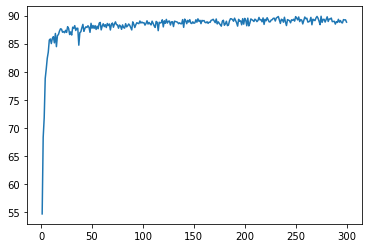

In [9]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [10]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/cifar10_DenseNet121_stn120211114014405.pkl
